In [2]:
#Authors: Eli Gumble, Peter Brommer, Harry Brown
#Initialisation
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
from scipy import signal as sg
from scipy.interpolate import RectBivariateSpline as ReBiSpline 
from numpy import ma
from matplotlib import colors, ticker, cm
#from matplotlib.mlab import bivariate_normal
from random import choice
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

import timeit

%matplotlib inline

from PIL import Image

In [3]:
# Read grids from image
im = Image.open("cc_fin.bmp")
pic = np.array(im)


In [4]:
scale = 0.25 #m per pixel
Nx = pic[:,0,0].size #N appears to be resolution
Ny = pic[0,:,0].size
xmin=-scale*0.5*(Nx-1)
xmax=scale*0.5*(Nx-1)
ymin=-scale*0.5*(Ny-1)
ymax=scale*0.5*(Ny-1)
x = np.linspace(xmin, xmax, Nx) # This is defining the axes and full space
y = np.linspace(ymin, ymax, Ny)
Y, X= np.meshgrid(y, x)
tr = np.zeros((Nx,Ny))
destp=np.zeros((Nx,Ny))
wght=np.zeros((Nx,Ny))
intens=np.zeros((Nx,Ny))
q_alpha=np.zeros((Nx,Ny))
expdist=np.zeros((2*Nx-1,2*Ny-1))
dest=np.zeros((2))
start=np.zeros((2))
grad=np.zeros((2,Nx,Ny))
vel=np.asarray([0.,0.])
pos=np.asarray([0.,0.])
#desdirx=ReBiSpline(x,y,grad[0,:,:],s=2)
#desdiry=ReBiSpline(x,y,grad[1,:,:],s=2)
intens[:]=0.

#print(route)
#parameters
t_track=50.
dt=0.1
dvel=1.
tau=5.
isigma=1./2.
conv_thresh=10.e-4
precision=1.**2 #distance to target.
eps=0.025 #random motion contribution, same for all

In [5]:
##Set up map


#Create blank arrays
z = np.zeros((Nx,Ny))
g_max=np.zeros((Nx,Ny))
g_nat=np.zeros((Nx,Ny))

g_nat=np.maximum(np.ones_like(g_nat),np.float64(pic[:,:,0]))
g_max=np.maximum(np.ones_like(g_max),np.float64(pic[:,:,1]))
z=g_nat

track_labels=pic[:,:,2];

numpoints=np.max(track_labels)

point=np.zeros((numpoints,2))

for i in range(0,Nx):
    for j in range(0,Ny):
        if (track_labels[i,j]>0):
            point[track_labels[i,j]-1]=np.array([i,j])

#define initial and max ground potentials
#z[:,:]=1.
#g_max[:,:]=80.
#Set ground potentials
#z[35:200,15:40]=100;z[50:120,70:85]=100;z[80:110,85:120]=100;z[0:20,70:120]=100;z[20:50,40:95]=100;
#g_max[35:200,15:40]=100;g_max[50:120,70:85]=100;g_max[80:110,85:120]=100;g_max[0:20,70:120]=100;g_max[20:50,40:95]=100;
#z[120:201,70:85]=80;
#z[50:200,40:70]=30;
#z[100:200,85:120]=30;
#g_nat=z

print (point)

# Trails (start and end point)
route=np.array([[[-2.5,14.],[24.,-9.75]],
                [[-2.5,14.],[24.,2.5]],
                [[-2.5,14.],[-24.,9.75]],
                [[24.,-9.75],[-2.75,14.]],
                [[24.,-9.75],[-24.,9.75]],
                [[24.,2.5],[-2.75,14.]],
                [[24.,2.5],[-24.,9.75]],
                [[-24.,10.],[-2.75,14.]],
                [[-24.,10.],[24.,-9.75]],
                [[-24.,10.],[24.,2.5]]])

[[450.  67.]
 [449. 347.]
 [449.  69.]
 [449. 345.]
 [449. 344.]
 [449. 343.]
 [449. 367.]
 [449. 350.]
 [450. 271.]
 [450. 349.]
 [449. 264.]
 [449. 265.]
 [450. 350.]
 [450. 348.]
 [449. 266.]
 [450. 351.]
 [450. 345.]
 [450. 343.]
 [449. 368.]
 [449. 267.]
 [450. 255.]
 [450. 254.]
 [449. 369.]
 [448. 351.]
 [415. 246.]
 [450. 367.]
 [445. 370.]
 [450. 257.]
 [450. 264.]
 [450. 252.]
 [450. 265.]
 [450. 266.]
 [450. 369.]
 [450. 268.]
 [411. 370.]
 [448. 246.]
 [450. 247.]
 [  0.   0.]
 [ 94. 328.]
 [312. 337.]
 [  0.   0.]
 [410. 338.]
 [ 95. 315.]
 [  0.   0.]
 [316. 337.]
 [  0.   0.]
 [315. 337.]
 [  0.   0.]
 [274. 338.]
 [450. 370.]
 [ 94. 334.]
 [ 95. 190.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [ 95. 314.]
 [  0.   0.]
 [ 95. 309.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [ 95. 308.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [ 95. 336.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]

In [6]:
#Setup weight matrix, here trapezoid rule.
wght[:,:]=1
wght[1:-1,:]=2
wght[:,1:-1]=2
wght[1:-1,1:-1]=4
wght*=0.25*((x[-1]-x[0])/(Nx-1))*((y[-1]-y[0])/(Ny-1))
#0.25*((x[-1]-x[0])/(N-1))*((y[-1]-y[0])/(N-1))
#np.exp(-np.sqrt((x[:,None]-x[N/2])**2+(y[None,:]-y[N/2])**2))*z[:,:]


In [7]:
# Setup distance matrix
for xi in range(1,Nx+1):
    for yi in range(1,Ny+1):
        expdist[xi-1,yi-1]=np.exp(-isigma*np.sqrt((x[Nx-xi]-xmin)**2+(y[Ny-yi]-ymin)**2))
        expdist[-xi,-yi]  = expdist[xi-1,yi-1]
        expdist[-xi,yi-1] = expdist[xi-1,yi-1]
        expdist[xi-1,-yi] = expdist[xi-1,yi-1]
        
# find index range > conv_thresh
subexpdist=expdist[(expdist>conv_thresh).any(1)]
subexpdist=subexpdist[:, np.any(subexpdist>conv_thresh, axis=0)]
#subexpdist=subexpdist[:,np.any(subexpdist>convthresh, axis=0)]
#expdist[subexpdist]=0.
subexpdist.shape

(111, 111)

In [8]:
def calc_tr_new():
    tr[:,:]=sg.convolve2d(z[:,:]*wght[:,:],subexpdist[:,:],mode="same")

In [10]:
#Integrate z, trapezoid rule eq 20
def calc_tr():
    global xi,yi,tr,expdist,z,wght,Nx,Ny
    for xi in range(0,Nx): 
        for yi in range(0,Ny):
            tr[xi,yi]=np.sum(expdist[Nx-1-xi:2*Nx-1-xi,Ny-1-yi:2*Ny-1-yi]*z[:,:]*wght[:,:])

In [14]:
timeit.timeit(calc_tr,number=1)

210.21550011634827

In [65]:
timeit.timeit(calc_tr_new,number=1)

13.097643987000083

ValueError: Contour levels must be increasing

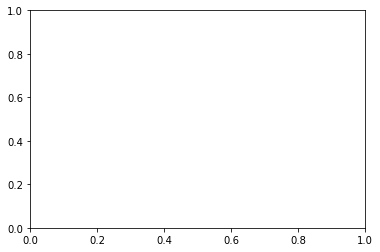

In [8]:
# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
#z = ma.masked_where(z <= 0, z)
#calc_tr()

# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
cs = plt.contourf(X, Y, tr, levels=np.linspace(tr.min(),tr.max(),1000),cmap=cm.PuBu_r)

# Alternatively, you can manually set the levels
# and the norm:
#lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
#levs = np.power(10, lev_exp)
#cs = plt.contourf(X, Y, z, levs, norm=colors.LogNorm())

# The 'extend' kwarg does not work yet with a log scale.

cbar = plt.colorbar()
#plt.scatter(track[0:1999,0],track[0:1999,1])
plt.show()

In [9]:
#set up walker
def set_up_walker(route_id):
    global vel,pos,track,intens,dest,start,route
    #START AND FINISH POSITIONS
    start=np.array(route[route_id,0,:])
    dest=np.array(route[route_id,1,:])
    #INITIAL VELOCITY AND POSTION
    vel=np.array([0.,0.])
    pos=np.array(start)
    #ARRAY CONTAINING WHERE THE WALKER GOES
    track=np.zeros((2000,2))


In [10]:

#Calculate gradients eq 19
#Trail gradient
def setup_potentials():
    global grad,desdirx,desdiry,dest
    grad=0.002*np.array(np.gradient(tr))

#Destination potential
    destp=-np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
#Combine gradients
    grad+=np.array(np.gradient(destp)[:])
#Normalise
#grad[:,:,:]/=(np.sqrt(grad[0,:,:]**2+grad[1,:,:]**2))
    desdirx=ReBiSpline(x,y,grad[0,:,:],s=2)
    desdiry=ReBiSpline(x,y,grad[1,:,:],s=2)

In [11]:
def detect_local_maxima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_max = (filters.maximum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_maxima = local_max ^ eroded_background
    return np.where(detected_maxima) 

In [12]:
def plot_potentials():
    global dest
    total_pot=np.zeros((Nx,Ny))
    total_pot=-np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
    total_pot+=0.005*tr
    maxima=detect_local_maxima(total_pot)
    cs = plt.contourf(X, Y, total_pot, levels=np.linspace(total_pot.min(),total_pot.max(),1000),cmap=cm.PuBu_r)
    cbar = plt.colorbar()
    print(maxima)
    plt.scatter(x[maxima[0]],y[maxima[1]])
    plt.show


(array([252], dtype=int64), array([223], dtype=int64))


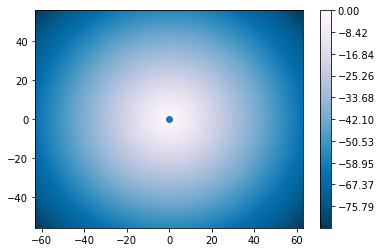

In [13]:
#calc_tr_new()
plot_potentials()

NameError: name 'track' is not defined

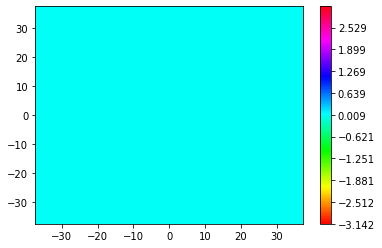

In [14]:
#Plot the direction
scgrad=np.arctan2(grad[1],grad[0])
levels = np.linspace(-np.pi, np.pi, 360)
cs = plt.contourf(X, Y,scgrad, levels=levels,cmap=cm.hsv)

cbar = plt.colorbar()
plt.scatter(track[0:1999,0],track[0:1999,1])
plt.show()


In [14]:
def calc_path():
    global pos,vel,intens,track,dest,dvel,tau;
#    for i in range(0,399):
    i=0
    hist=10
    samp=10
    avpos=np.zeros((2,hist))
    while (np.dot(pos-dest,pos-dest)>precision and i<2000):
    #Integrator eq 5
        #pos+=dt*vel
        if (i%samp==0): avpos[:,(i%hist*samp)//samp]=pos[:]
        gradmagnitude=max(0.0001,np.sqrt(desdirx(pos[0],pos[1])**2+desdiry(pos[0],pos[1])**2))
        xi=np.array(np.random.normal(0,1,2))
        vel[0]+=dvel*desdirx(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[0]
        vel[1]+=dvel*desdiry(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[1]
        #print (i,pos,vel,(dvel/tau)*desdirx(pos[0],pos[1])/gradmagnitude,(dvel/tau)*desdiry(pos[0],pos[1])/gradmagnitude)
        pos+=dt*vel
        track[i,:]=pos[:]
        intens[int((pos[0]-xmin)*(Nx-1)/(xmax-xmin)),int((pos[1]-ymin)*(Ny-1)/(ymax-ymin))]+=1.
        i+=1
        if (i%(hist*samp)==0):
            meanpos=np.mean(avpos,axis=1)
            if (np.dot(pos-meanpos,pos-meanpos)<precision): 
                print ("Stalled progress ",pos,meanpos,vel)
                break
    if (i==2000): print ("Missed goal ",dest,pos)           
    return i    
#stopping condition    

In [15]:
# Calculate Q_alpha (strength of markings) eq 15
def update_ground():
    global q_alpha,intens,z,g_max,t_track,g_nat
    q_alpha=intens*(1.-z/g_max)
# Time evolution of ground potential
#    zdiff=(1./t_track)*(g_nat-z)+q_alpha
    z+=(1./t_track)*(g_nat-z)+q_alpha
#    cs = plt.contourf(X, Y, zdiff, cmap=cm.PuBu_r)
#    cbar = plt.colorbar()
#    plt.show
#    z[140:160,45:75]

In [16]:
def plot_path():
    cs = plt.contourf(X, Y, z, levels=np.linspace(z.min(),z.max(),1000),cmap=cm.PuBu_r)
    cbar = plt.colorbar()
    plt.show
    #plt.scatter(track[0:1999,0],track[0:1999,1])

(array([149, 149, 150, 150]), array([149, 150, 149, 150]))


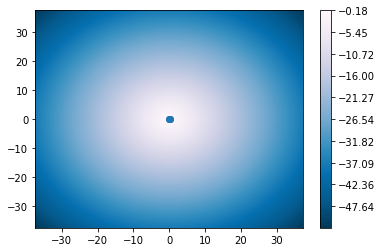

In [18]:
plot_potentials()

In [17]:
for i in range(0,2):
    calc_tr_new()
    intens[:]=0.
    for j in range(0,10):
        set_up_walker(np.random.randint(0,len(route)))
        setup_potentials()
        print (i, start," -> ", dest, pos, calc_path())
    update_ground()
    #plot_path()

IndexError: index 508 is out of bounds for axis 0 with size 505

In [ ]:
precision=1.

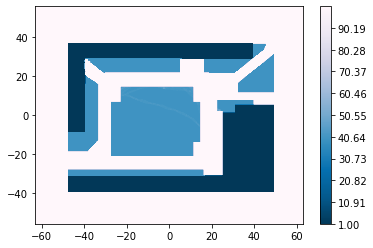

In [31]:
plot_path()

In [75]:
for i in range(0,Nx):
    for j in range(0,Ny):
        if (np.isnan(z[i,j])):
            print (i,j,g_max[i,j],pic[i,j,0])
        

In [60]:
g_nat[:,:]-pic[:,:,0]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [78]:
z.dtype

dtype('float64')